In [1]:
!pip install prophet

In [2]:
from prophet import Prophet

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, Bounds

In [4]:
file_path = "/content/drive/MyDrive/Cleaned_Data/export_data.csv"

df = pd.read_csv(file_path)
#df["Date"] = pd.to_datetime(df["Date"])
df.head(2)

,Date,AAPL,ABCB,ACGL,ADBE,ADI,ADP,ADSK,AEP,AMAT,...,VLY,VRTX,WABC,WAFD,WBA,WERN,WSFS,WTFC,XEL,ZION
0,2000-01-03,0.088754,0.011765,-0.089109,-0.025093,-0.030242,-0.034803,-0.011111,-0.021400,-0.001480,...,-0.037946,0.073214,-0.080537,-0.069620,-0.023504,-0.031111,-0.029703,-0.032787,-0.025641,-0.062302
1,2000-01-04,-0.084310,-0.011628,-0.005435,-0.083889,-0.050590,0.000000,-0.048689,0.011928,-0.049407,...,-0.051044,-0.079867,-0.017031,-0.023809,-0.037199,-0.002294,-0.030612,0.000000,0.023026,-0.048424


In [5]:
type(df["Date"])  #I check this because I cannot concatenate a timestamp data type below, so I decided to leave it as a series and then convert to date

pandas.core.series.Series

# 1 Testing Facebook Prophet Time Series Model

In [6]:
#Prophet is a univariate time series additive model. Therefore, we will need to forecast the returns of each stock one at a time,
#using the format specified by Facebook Prophet documentation:

ds = []
y = []

for i in range(0, 252):
  ds.append(df.Date.iloc[i])
  y.append(df.AAPL.iloc[i])

In [7]:
ds_df = pd.DataFrame(ds)
y_df = pd.DataFrame(y)
test_df = pd.concat([ds_df, y_df], axis= 1 )
test_df.columns = ["ds", "y"]
test_df["ds"] = pd.to_datetime(test_df["ds"])
test_df.tail(2)

,ds,y
250,2000-12-28,0.00000
251,2000-12-29,0.00422


In [8]:
m = Prophet()
m.fit(test_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntssnk7k/h4iivszt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntssnk7k/kbuaenms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28461', 'data', 'file=/tmp/tmpntssnk7k/h4iivszt.json', 'init=/tmp/tmpntssnk7k/kbuaenms.json', 'output', 'file=/tmp/tmpntssnk7k/prophet_model__ny7ow6/prophet_model-20240318225237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
future = m.make_future_dataframe(periods = 252)  #We want to test how it forecasts returns approximately one year into the future
future        #It not only generates future dates but re-generates past dates and then adds 252 future dates. That's why our predictor below predicts in sample first.

,ds
0,2000-01-03
1,2000-01-04
2,2000-01-05
3,2000-01-06
4,2000-01-07
...,...
499,2001-09-03
500,2001-09-04
501,2001-09-05
502,2001-09-06


In [10]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[252:]  #It first produces an in_sample fit by default. Thus, we need iloc to find the actual...
                                                   #...forecasts out of sample. Yhat is the prediction, the others are the bounds of the confidence interval.

,ds,yhat,yhat_lower,yhat_upper
252,2000-12-30,0.035709,-0.032842,0.109335
253,2000-12-31,0.035658,-0.031345,0.105056
254,2001-01-01,-0.004401,-0.076218,0.064210
255,2001-01-02,-0.016597,-0.086678,0.048537
256,2001-01-03,-0.017023,-0.088195,0.049933
...,...,...,...,...
499,2001-09-03,-0.016986,-0.084099,0.049724
500,2001-09-04,-0.029181,-0.099725,0.035941
501,2001-09-05,-0.029607,-0.096004,0.039664
502,2001-09-06,-0.020570,-0.088089,0.048008


In [11]:
help(Prophet.make_future_dataframe) #I will try without including history

Help on function make_future_dataframe in module prophet.forecaster:

make_future_dataframe(self, periods, freq='D', include_history=True)
    Simulate the trend using the extrapolated generative model.
    
    Parameters
    ----------
    periods: Int number of periods to forecast forward.
    freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
    include_history: Boolean to include the historical dates in the data
        frame for predictions.
    
    Returns
    -------
    pd.Dataframe that extends forward from the end of self.history for the
    requested number of periods.



In [12]:
future = m.make_future_dataframe(periods = 365, include_history = False)  #We want to test how it forecasts returns approximately one year into the future
future   #Now it skips the in_sample dates

,ds
0,2000-12-30
1,2000-12-31
2,2001-01-01
3,2001-01-02
4,2001-01-03
...,...
360,2001-12-25
361,2001-12-26
362,2001-12-27
363,2001-12-28


In [13]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]  #And now I don't need to use iloc

,ds,yhat,yhat_lower,yhat_upper
0,2000-12-30,0.035709,-0.033813,0.102879
1,2000-12-31,0.035658,-0.037764,0.104988
2,2001-01-01,-0.004401,-0.077020,0.064070
3,2001-01-02,-0.016597,-0.083522,0.051857
4,2001-01-03,-0.017023,-0.087910,0.051917
...,...,...,...,...
360,2001-12-25,-0.034934,-0.102094,0.031495
361,2001-12-26,-0.035360,-0.107154,0.032652
362,2001-12-27,-0.026323,-0.094748,0.044689
363,2001-12-28,-0.034502,-0.098808,0.037080


In [14]:
forecast["yhat"].mean()

-0.007786967543508904

In [15]:
print(df.iloc[251])   #Yields the 29th december 2000
print(df.iloc[252])   #Yields the 2nd of February 2001
#We need to use 365 days for forecasting period with prophet instead of 252, because prophet uses 365 days a year, whereas our data has 252 days a year (only trading days)

Date    2000-12-29
AAPL       0.00422
ABCB      0.020408
ACGL      0.043478
ADBE     -0.055781
           ...    
WERN           0.0
WSFS      0.040404
WTFC      0.011905
XEL      -0.002146
ZION      0.006042
Name: 251, Length: 111, dtype: object
Date    2001-01-02
AAPL           0.0
ABCB           0.0
ACGL     -0.033333
ADBE     -0.196652
           ...    
WERN     -0.091912
WSFS     -0.029126
WTFC     -0.003922
XEL      -0.025806
ZION      -0.04004
Name: 252, Length: 111, dtype: object


In [16]:
df.AAPL.iloc[251:499].mean() #Prediction is not the best. I use the mean because in mean_variance I need to specifiy the expected returns parameter

0.0024413476322557998

In [17]:
#We will use more data this time, and try to find the best hyperparameters of the model
ds = []
y = []

for i in range(0, 1000):   #We changed the range to add more the data for the model
  ds.append(df.Date.iloc[i])
  y.append(df.AAPL.iloc[i])

In [18]:
ds_df = pd.DataFrame(ds)
y_df = pd.DataFrame(y)
test_df = pd.concat([ds_df, y_df], axis= 1 )
test_df.columns = ["ds", "y"]
test_df.tail(2)

,ds,y
2998,2011-12-01,0.014992
2999,2011-12-02,0.004563


In [19]:
#HYPERPARAMETER TUNING
#Here we do cross-validation to assess prediction performance on a horizon of 252 days, starting with 700 days of
#training data in the first cutoff and then making predictions every 180 days
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

#The hyperparameters we want to tune
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(test_df)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")  #Last one is parallelization method of cross validation
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntssnk7k/nyyke8ok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpntssnk7k/3sjid632.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92999', 'data', 'file=/tmp/tmpntssnk7k/nyyke8ok.json', 'init=/tmp/tmpntssnk7k/3sjid632.json', 'output', 'file=/tmp/tmpntssnk7k/prophet_model1_vhpp41/prophet_model-20240318225239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 19 forecasts with cutoffs between 2002-01-18 00:00:00 and 2010-12-02 00:00:00
INFO:prophet:Applying in parallel with <conc

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.030348
1                     0.001                     0.10  0.029433
2                     0.001                     1.00  0.027433
3                     0.001                    10.00  0.027328
4                     0.010                     0.01  0.025339
5                     0.010                     0.10  0.025474
6                     0.010                     1.00  0.025476
7                     0.010                    10.00  0.025469
8                     0.100                     0.01  0.025513
9                     0.100                     0.10  0.025683
10                    0.100                     1.00  0.025653
11                    0.100                    10.00  0.025699
12                    0.500                     0.01  0.025982
13                    0.500                     0.10  0.026246
14                    0.500                     1.00  0

In [20]:
best_params = all_params[np.argmin(rmses)]
print(best_params)    #Judged Based on the Root-Mean_Square-Error metric, suggested by the Prophet documentation

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


# 2 Testing Garch Volatility Model

The GARCH Model needs two parameters to be defined. The number of lagged variances (p) that we will consider when running the model, and the number of lagged residual errors (q). The first one can be determined with by calculating the autocorrelation of the data of returns, and the second one by calculating the partial autocorrelation of the same data.

In [21]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 6.0 MB/s eta 0:00:00


In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

In [23]:
aapl_data = [df.AAPL.iloc[i] for i in range(0, 252)]
aapl_data = pd.Series(aapl_data)

mean = aapl_data.mean()

squared_data = [(i - mean)**2 for i in aapl_data]   #We do this to plot the autocorrelation and partial autocorrelation plots
squared_data = pd.Series(squared_data)
len(squared_data)

252

[]

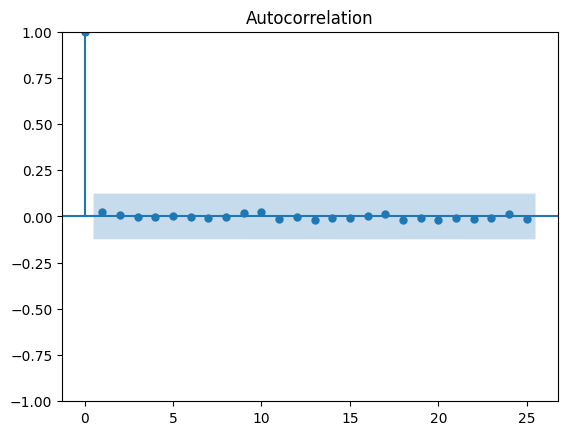

In [24]:
#Create Autocorrelation Function Plot. The blue area represents the confidence interval
plot_acf(squared_data)
plt.plot() #Since there is few to no autocorrelation, we choose p = 1. We assume that there most be some autocorrelation,
            # because research shows variance does have some autocorrelation, but we could not find a lot here, so we only use one lag

[]

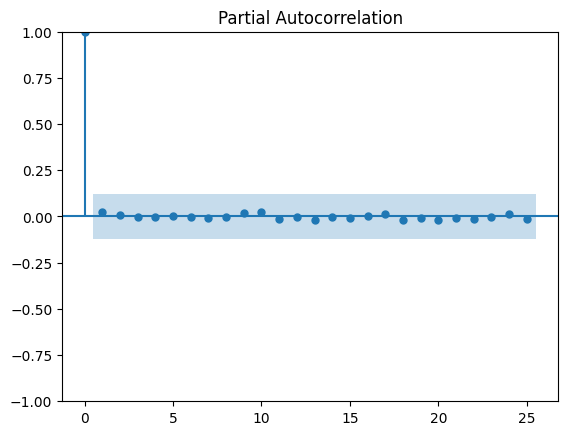

In [25]:
#Create Partial Autocorrelation Function Plot. The blue area represents the confidence interval
plot_pacf(squared_data)
plt.plot()  #Again, we will choose q = 1

In [26]:
help(arch_model)  #We will use a vol = GARCH, mean = "Constant" (I have seen many examples where they assume this),
                      #p = 1, q = 1, and default error distribution (gaussian)

Help on function arch_model in module arch.univariate.mean:

arch_model(y: 'ArrayLike | None', x: 'ArrayLike2D | None' = None, mean: "Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero']" = 'Constant', lags: 'None | int | list[int] | Int32Array | Int64Array' = 0, vol: "Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']" = 'GARCH', p: 'int | list[int]' = 1, o: 'int' = 0, q: 'int' = 1, power: 'float' = 2.0, dist: "Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error']" = 'normal', hold_back: 'int | None' = None, rescale: 'bool | None' = None) -> 'HARX'
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : ndarray, Series, None
        The dependent variable
    x : ndarray, DataFrame, optional
        Exogenous regressors.  Ignored if model does not permit exogenous
        regressors.
    mean : str, optional
        Name of the mean model.  Curr

In [27]:
m = arch_model(aapl_data, mean = "Constant", vol = "GARCH", p = 1, q = 1)
res = m.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2057264.0147079309
Iteration:      2,   Func. Count:     16,   Neg. LLF: 280.15688207395107
Iteration:      3,   Func. Count:     22,   Neg. LLF: -358.78536395277627
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2328.21045909441
Iteration:      5,   Func. Count:     35,   Neg. LLF: -388.0272129706391
Iteration:      6,   Func. Count:     42,   Neg. LLF: 104140.00615877676
Iteration:      7,   Func. Count:     48,   Neg. LLF: -396.73719020076936
Iteration:      8,   Func. Count:     53,   Neg. LLF: -229.46753185958283
Iteration:      9,   Func. Count:     60,   Neg. LLF: -396.3026322629173
Iteration:     10,   Func. Count:     66,   Neg. LLF: -396.82571816977014
Iteration:     11,   Func. Count:     71,   Neg. LLF: -396.82930363197113
Iteration:     12,   Func. Count:     76,   Neg. LLF: -396.8293115702533
Iteration:     13,   Func. Count:     80,   Neg. LLF: -396.8293115699996
Optimization terminated successfully    (Exit mo

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003028. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [28]:
f = res.forecast(horizon = 252)
f.variance.values

array([[0.00159026, 0.00251847, 0.00309773, 0.00345923, 0.00368482,
        0.00382561, 0.00391346, 0.00396829, 0.00400251, 0.00402386,
        0.00403719, 0.00404551, 0.00405069, 0.00405393, 0.00405595,
        0.00405722, 0.004058  , 0.00405849, 0.0040588 , 0.00405899,
        0.00405911, 0.00405919, 0.00405923, 0.00405926, 0.00405928,
        0.00405929, 0.0040593 , 0.0040593 , 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00405931, 0.00405931,
        0.00405931, 0.00405931, 0.00405931, 0.00

# 3 Backtesting Mean-Variance Models with Time Series Forecasting

In [29]:
#This code snippet creates a class to suppress unnecessary output from Prophet
import os
import sys
import logging

# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [30]:
# Function to forecast returns using Facebook Prophet
def forecast_returns(returns_data):
    forecasted_returns_means = []
    for col in returns_data.columns[1:]:  # Exclude the date column
        # Prepare data for Prophet
        df = returns_data[['Date', col]].copy()
        df.columns = ['ds', 'y']
        df["ds"] = pd.to_datetime(df["ds"])

        # Create and fit Prophet model
        model = Prophet(daily_seasonality=False, yearly_seasonality= True, changepoint_prior_scale= 0.01, seasonality_prior_scale= 0.01 )
        with suppress_stdout_stderr():
          model.fit(df)

        # Make future dataframe for one year ahead
        future = model.make_future_dataframe(periods=365, include_history = False)

        # Forecast returns
        forecast = model.predict(future)

        # Extract forecasted returns for the next year
        forecast_next_year = forecast['yhat'].values

        # Calculate mean of forecasted returns
        forecasted_return_mean = forecast_next_year.mean()
        forecasted_returns_means.append(forecasted_return_mean)

    # Convert list to array
    forecasted_returns_means = np.array(forecasted_returns_means)

    # Annualize forecasted returns means
    annualized_forecasted_returns_means = np.power(1 + forecasted_returns_means, 252) - 1

    return annualized_forecasted_returns_means


# Function to forecast volatility using GARCH model
def forecast_volatility(returns_data):
    vol_forecasts = []
    for col in returns_data.columns[1:]:
        # Fit GARCH model
        model = arch_model(returns_data[col], mean = "Constant", vol = "GARCH", p = 1, q = 1, rescale= False)
        result = model.fit(disp='off')

        # Forecast one year ahead
        forecasts = result.forecast(horizon=252)

        # Calculate forecasted volatility for the next year (model returns variance, not std)
        forecasted_volatility_next_year = np.sqrt(forecasts.variance.values[-1])

        vol_forecasts.append(forecasted_volatility_next_year)

    # Convert list to array
    vol_forecasts = np.array(vol_forecasts)

    return vol_forecasts


# Function to forecast correlation matrix using rolling window
def forecast_correlation_matrix(returns_data):
    rolling_corr = returns_data.rolling(window=252).corr(numeric_only= True)

    # Extract correlation matrix for the last day of the year
    correlation_matrix_next_year = rolling_corr.iloc[-110:]

    return correlation_matrix_next_year

In [31]:
#Functions used before for the Classical Mean Variance backtesting

def portfolio_gross_return (r, w):
  "Expected return of the portfolio is the weighted average of returns of the assets composing it. Not adjusted for costs. Return as % of capital invested"

  if type(r) == type(df.iloc[1]):
    #We need to remove the date column
    r = r.drop(["Date"])
  else:
    pass
  #r represents the returns of each asset
  #w represents the weights that go to each asset

  return np.dot(r, w)

def portfolio_volatility (w, covar):
  "Portfolio volatility is the following matrix multiplication: w^T . covariance_matrix . w"
  return np.sqrt(np.dot(w.T, np.dot(covar, w)))

def adjusted_port_return (portfolio_gross_return, initial_weights,  desired_weights, transaction_rate):
  "Desired weights are those obtained from the optimization. Transaction rate represents the % of transactions (change in weights) that represent costs"
  #We think of transaction costs calculation as a % of returns derived from the rate of weight changes that represent costs
  # % adjusted return = % gross return - % transaction cost
  #                 = % gross return - (sum(transaction_rate * weight changes))
  # Recall that because we used the .pct_change() pandas function to calculate returns, all returns are percentage returns

  vector_transaction_costs = transaction_rate * np.abs(initial_weights - desired_weights)
  total_transaction_costs = np.sum(vector_transaction_costs)
  adjusted_return = portfolio_gross_return - total_transaction_costs

  return adjusted_return

#MVP Optimization Model
def minimum_variance_portfolio (covariance_matrix, initial_weights):
  "This optimization method will find the highest return possible that one can get with the minimum risk: we will minimize the portfolio volatility"
  num_assets = len(initial_weights)

  #Set the weight constraints: all of them should be between 0 and 1 because we are working with a no-short strategy
  bounds = Bounds(0, 1)

  #Sum of weights should also equal 1 (100% of our capital)
  constraint_matrix = np.ones((1, num_assets))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  #Calculate portfolio volatility (but we do this because the function "minimize" needs a function as input in the first argument, not a function call)
  def port_vol (initial_weights, covariance_matrix):
    port_vol = portfolio_volatility(initial_weights, covariance_matrix)
    return port_vol

  result = minimize(port_vol, initial_weights, args = (covariance_matrix), method = "trust-constr", constraints = linear_constraint, bounds = bounds)

  return result

  #Max Sharpe Ratio Optimization Model
def neg_sharpe_ratio(weights, covar_matrix, expected_returns):
  portfolio_vol = portfolio_volatility(weights, covar_matrix)
  portfolio_ret = portfolio_gross_return(expected_returns, weights)
  return -portfolio_ret / portfolio_vol  # negative value for minimization

def sharpe_ratio_max (weights, covar_matrix, expected_returns):

  num_stocks = len(weights)

  # All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
  bounds = Bounds(0, 1)

  # Set the constraint that the sum of weights equals 1.
  constraint_matrix = np.ones((1, num_stocks))
  linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

  def neg_sh (weights, covar_matrix, expected_returns):
    sh = neg_sharpe_ratio(weights, covar_matrix, expected_returns)
    return sh

  # Minimize the negative Sharpe ratio (to maximize Sharpe ratio) using 'trust-constr' method with constraints and bounds.
  res_sharpe = minimize(neg_sh, weights, args = (covar_matrix, expected_returns), method='trust-constr', constraints=linear_constraint, bounds=bounds)

  return res_sharpe

## 3.1 Backtesting with Max Sharpe Ratio Strategy

In [32]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_Max_Sharpe_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns[1:])       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if day % rebalancing_period == 0 and day > 756:     #I will start rebalancing after the 3rd year, because the models need a large amount of data before the present good performance. Otherwise, I am losing computational efficiency without really having good predictions.

            # Forecast returns for the next year
            annualized_forecast_next_year = forecast_returns(returns.iloc[:day])

            # Forecast volatility for the next year
            forecasted_volatility_next_year = forecast_volatility(returns.iloc[:day])

            # Forecast correlation matrix for the next year
            correlation_matrix_next_year = forecast_correlation_matrix(returns.iloc[:day])

            # Calculate covariance matrix using the forecasted volatility and correlation matrix
            forecasted_covariance_matrix_next_year = np.matmul(np.matmul(np.diag(forecasted_volatility_next_year), correlation_matrix_next_year), np.diag(forecasted_volatility_next_year).T)
            forecasted_covariance_matrix_next_year = forecasted_covariance_matrix_next_year * 252    #Simple Annualizing method

            # Calculate Max Sharpe portfolio
            Max_Sharpe = sharpe_ratio_max(previous_weights, forecasted_covariance_matrix_next_year, annualized_forecast_next_year)
            weights = Max_Sharpe.x

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value *= (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Recalculate portfolio volatility (daily) and store value
            covariance_matrix = returns.iloc[:day].cov(numeric_only = True)
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights
        else:
            # Calculate portfolio returns(daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value *= (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov(numeric_only = True)

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [33]:
transaction_rate = 0.01

Max_shp_portfolio_values, Max_shp_adjusted_returns, Max_shp_portfolio_volatilities = backtest_Max_Sharpe_strategy(df, transaction_rate)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of 

In [34]:
Maxsharpe_returns_and_vol = pd.DataFrame({"Max Shp Portfolio Returns": Max_shp_adjusted_returns, "Max Shp Volatility": Max_shp_portfolio_volatilities })
Maxsharpe_returns_and_vol = Maxsharpe_returns_and_vol.dropna()
len(Maxsharpe_returns_and_vol)

5092

In [35]:
Maxsharpe_returns_and_vol["Rolling Sharpe Ratio"] = Maxsharpe_returns_and_vol["Max Shp Portfolio Returns"].rolling(252).mean() / Maxsharpe_returns_and_vol["Max Shp Volatility"].rolling(252).mean()
Maxsharpe_returns_and_vol

,Max Shp Portfolio Returns,Max Shp Volatility,Rolling Sharpe Ratio
2,0.007721,0.011441,NaN
3,-0.006257,0.019683,NaN
4,0.020144,0.016421,NaN
5,0.016604,0.020004,NaN
6,-0.016055,0.019952,NaN
...,...,...,...
5089,0.063983,0.015317,0.018485
5090,-0.037692,0.015341,0.006720
5091,0.032131,0.015349,0.013788
5092,-0.013506,0.015353,0.004983


## 3.2 Backtesting with MVP Strategy

In [36]:
# Function to backtest the Max-Sharpe optimization strategy with annual rebalancing
def backtest_MVP_strategy(returns, transaction_cost_rate):
    num_assets = len(returns.columns[1:])       #Returns meaning our daily return data: our dataframe
    num_days = len(returns)
    rebalancing_period = 252  # Number of trading days in a year
    investing_capital = 10000   #The capital to be used with this strategy
    initial_transaction_cost = np.sum(np.dot(np.ones(num_assets), 1/num_assets)) * transaction_cost_rate #Initial transaction cost (in %) resulting from buying the equally weighted portfolio (from 0 weighting to 1/n)
    initial_portfolio_value = investing_capital - initial_transaction_cost * investing_capital  #The amount we would invest, adjusted for initial cost. And we will see how it evolves over time
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    adjusted_returns = []
    portfolio_volatilities = []
    previous_weights = np.ones(num_assets) / num_assets  # Initial equally weighted portfolio

    for day in range(num_days):
        if day % rebalancing_period == 0 and day > 756:     #I will start rebalancing after the 3rd year, because the models need a large amount of data before the present good performance. Otherwise, I am losing computational efficiency without really having good predictions.

            # Forecast volatility for the next year (I only need to forecast volatility for the MVP Strategy)
            forecasted_volatility_next_year = forecast_volatility(returns.iloc[:day])

            # Forecast correlation matrix for the next year
            correlation_matrix_next_year = forecast_correlation_matrix(returns.iloc[:day])

            # Calculate covariance matrix using the forecasted volatility and correlation matrix
            forecasted_covariance_matrix_next_year = np.matmul(np.matmul(np.diag(forecasted_volatility_next_year), correlation_matrix_next_year), np.diag(forecasted_volatility_next_year).T)
            forecasted_covariance_matrix_next_year = forecasted_covariance_matrix_next_year * 252    #Simple Annualizing method

            # Calculate Max Sharpe portfolio
            MVP = minimum_variance_portfolio(forecasted_covariance_matrix_next_year, previous_weights)
            weights = MVP.x

            # Calculate portfolio returns (daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], weights)

            # Adjust returns for transaction costs
            adjusted_return = adjusted_port_return(portfolio_return, previous_weights, weights, transaction_cost_rate )

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value *= (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            # Recalculate portfolio volatility (daily) and store value
            covariance_matrix = returns.iloc[:day].cov(numeric_only = True)
            portfolio_volatility_value = portfolio_volatility(weights, covariance_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

            #In the next period, optimized weights in this period will be the previous weights
            previous_weights = weights
        else:
            # Calculate portfolio returns(daily)
            portfolio_return = portfolio_gross_return(returns.iloc[day], previous_weights)

            #If there is no rebalancing, there are no transaction costs for this period
            adjusted_return = portfolio_return

            # Store adjusted returns
            adjusted_returns.append(adjusted_return)

            # Update portfolio value
            portfolio_value *= (1 + adjusted_return)

            # Store portfolio value
            portfolio_values.append(portfolio_value)

            #Calculate the covariance up to this point, to track volatility (even if we do not rebalance we calculate volatility)
            covar_data = returns.iloc[:day]
            covar_matrix = covar_data.cov(numeric_only = True)

            # Recalculate portfolio volatility (daily) and store value
            portfolio_volatility_value = portfolio_volatility(previous_weights, covar_matrix)
            portfolio_volatilities.append(portfolio_volatility_value)

    return portfolio_values, adjusted_returns, portfolio_volatilities

In [37]:
transaction_rate = 0.01

MVP_portfolio_values, MVP_adjusted_returns, MVP_portfolio_volatilities = backtest_MVP_strategy(df, transaction_rate)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of 

In [38]:
MVP_returns_and_vol = pd.DataFrame({"MVP Portfolio Returns": MVP_adjusted_returns, "MVP Volatility": MVP_portfolio_volatilities })
MVP_returns_and_vol = MVP_returns_and_vol.dropna()
len(MVP_returns_and_vol)

5092

In [39]:
MVP_returns_and_vol["Rolling Sharpe Ratio"] = MVP_returns_and_vol["MVP Portfolio Returns"].rolling(252).mean() / MVP_returns_and_vol["MVP Volatility"].rolling(252).mean()
MVP_returns_and_vol

,MVP Portfolio Returns,MVP Volatility,Rolling Sharpe Ratio
2,0.007721,0.011441,NaN
3,-0.006257,0.019683,NaN
4,0.020144,0.016421,NaN
5,0.016604,0.020004,NaN
6,-0.016055,0.019952,NaN
...,...,...,...
5089,0.069712,0.014136,-0.001377
5090,-0.036613,0.014168,-0.013936
5091,0.028671,0.014176,-0.006656
5092,-0.011943,0.014180,-0.015523


## 3.3 Comparison Plots

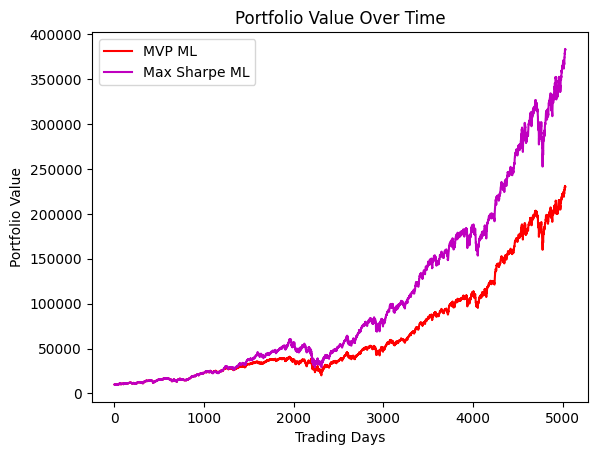

In [43]:
#Again we exclude COVID times
plt.plot(MVP_portfolio_values[0:5030], label = "MVP ML", color = "r")
plt.plot(Max_shp_portfolio_values[0:5030], label = "Max Sharpe ML", color = "m")
plt.title("Portfolio Value Over Time")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

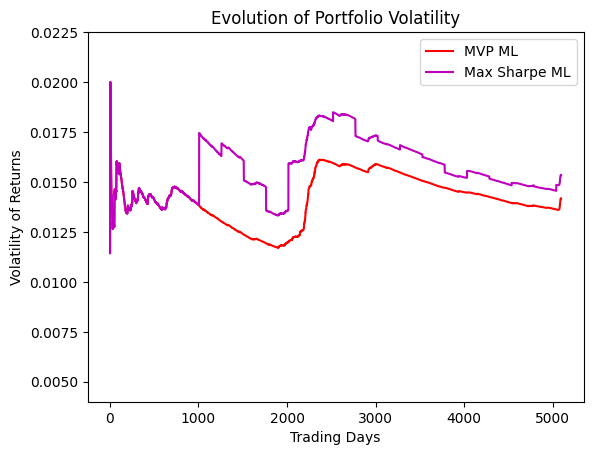

In [44]:
plt.plot(MVP_portfolio_volatilities, label = "MVP ML", color = "r")
plt.plot(Max_shp_portfolio_volatilities, label = "Max Sharpe ML", color = "m")
plt.title("Evolution of Portfolio Volatility")
plt.xlabel("Trading Days")
plt.ylabel("Volatility of Returns")
plt.ylim(0.004, 0.0225)
plt.legend()
plt.show()

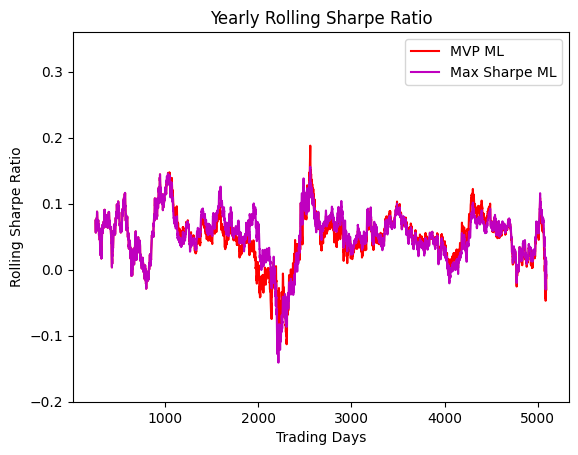

In [45]:
plt.plot(MVP_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "MVP ML", color = "r")
plt.plot(Maxsharpe_returns_and_vol["Rolling Sharpe Ratio"].dropna(), label = "Max Sharpe ML", color = "m")
plt.title("Yearly Rolling Sharpe Ratio")
plt.xlabel("Trading Days")
plt.ylabel("Rolling Sharpe Ratio")
plt.ylim(-0.20, 0.36)
plt.legend()
plt.show()